In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
N=100000
number_list = range(1,6)
churn_days=10 
lead_time=1 #на сколько раньше(если MS и lead_time=1 то за месяц мы хотим найти отток) мы хотим определить отток чтобы успеть сделать камп по удержанию
prediction_window = 1 #период времени в рамках которого мы хотим найти отток, 1 т.е. в течение месяца(MS).

In [3]:
customer_id=[random.choice(number_list) for i in range(N)]

In [4]:
def random_dates(start, end, n=N):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

In [5]:
start = pd.to_datetime('1998-01-01')
end = pd.to_datetime('2021-01-01')
t1=random_dates(start, end)

In [6]:
df=pd.DataFrame({'customer_id':customer_id,'date':t1})
df.sort_values(['date','customer_id'],ascending=[True,True],inplace=True)

In [7]:
df

,customer_id,date
72686,4,1998-01-01 01:41:13
52046,4,1998-01-01 04:31:38
66273,3,1998-01-01 05:05:38
2473,1,1998-01-01 06:46:46
6536,3,1998-01-01 09:46:23
...,...,...
6822,2,2020-12-31 16:58:53
26030,3,2020-12-31 17:13:42
89473,3,2020-12-31 19:33:56
11670,2,2020-12-31 20:49:03


In [8]:
def label_customer(customer_id, customer_transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1, return_trans = False):

    
    assert(prediction_date in ['MS', 'SMS']), "Prediction day must be either 'MS' or 'SMS'"
    assert(customer_transactions['customer_id'].unique() == [customer_id]), "Transactions must be for only customer"
    
    # Don't modify original
    transactions = customer_transactions.copy()
    
    # Make sure to sort chronalogically
    transactions.sort_values(['date'], inplace = True)
    
    # Create next transaction date by shifting back one transaction
    transactions['next_transaction_date'] = transactions['date'].shift(-1)
    
    # Find number of days between membership expiration and next transaction
    transactions['difference_days']=(transactions['next_transaction_date']-transactions['date'])/np.timedelta64(1, 'D')
    
    # Determine which transactions are associated with a churn
    transactions['churn'] = transactions['difference_days'] > churn_days
    
    # Find date of each churn
    transactions.loc[transactions['churn'] == True, 
                     'churn_date'] = transactions['date']

    # Range for cutoff times is from first to (last + 1 month) transaction
    first_transaction = transactions['date'].min()
    last_transaction = transactions['date'].max()
    start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
    
    # Handle December
    if last_transaction.month == 12:
        end_date = pd.datetime(last_transaction.year + 1, 1, 1)
    else:
        end_date = pd.datetime(last_transaction.year, last_transaction.month + 1, 1)
    
    # Make label times dataframe with cutoff times corresponding to prediction date
    label_times = pd.DataFrame({'cutoff_time': pd.date_range(start_date, end_date, freq = prediction_date),
                                'customer_id': customer_id
                               })
    
    # Use the lead time and prediction window parameters to establish the prediction window 
    # Prediction window is for each cutoff time
    label_times['prediction_window_start'] = label_times['cutoff_time'].shift(-lead_time)
    label_times['prediction_window_end'] = label_times['cutoff_time'].shift(-(lead_time + prediction_window))
    
    previous_churn_date = None

    # Iterate through every cutoff time
    for i, row in label_times.iterrows():
        
        # Default values if unknown
        churn_date = pd.NaT
        label = np.nan
        # Find the window start and end
        window_start = row['prediction_window_start']
        window_end = row['prediction_window_end']
        # Determine if there were any churns during the prediction window
        churns = transactions.loc[(transactions['churn_date'] >= window_start) & 
                                  (transactions['churn_date'] < window_end), 'churn_date']

        # Positive label if there was a churn during window
        if not churns.empty:
            label = 1
            churn_date = churns.values[0]

            # Find number of days until next churn by 
            # subsetting to cutoff times before current churn and after previous churns
            if not previous_churn_date:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date)].index
            else:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                             (label_times['cutoff_time'] > previous_churn_date)].index

            # Calculate days to next churn for cutoff times before current churn
            label_times.loc[before_idx, 'days_to_churn'] = (churn_date - label_times.loc[before_idx, 
                                                                                         'cutoff_time']).\
                                                            dt.total_seconds() / (3600 * 24)
            previous_churn_date = churn_date
        # No churns, but need to determine if an active member
        else:
            # Find transactions before the end of the window that were not cancelled
            transactions_before = transactions.loc[(transactions['date'] < window_end)].copy()
            # If the membership expiration date for this membership is after the window start, the custom has not churned
            if np.any(transactions_before['date'] >= window_start):
                label = 0

        # Assign values
        label_times.loc[i, 'label'] = label
        label_times.loc[i, 'churn_date'] = churn_date
        
        # Handle case with no churns
        if not np.any(label_times['label'] == 1):
            label_times['days_to_churn'] = np.nan
            label_times['churn_date'] = pd.NaT
        
    if return_trans:
        return label_times.drop(columns = ['customer_id']), transactions
    
    return label_times[['customer_id', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']].copy()

In [9]:
CUSTOMER_ID = 5
customer_transactions = df.loc[df['customer_id'] == CUSTOMER_ID].copy()

In [10]:
label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'MS', churn_days = 10, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)

<ipython-input-8-c507fea34bae>:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
<ipython-input-8-c507fea34bae>:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_date = pd.datetime(last_transaction.year + 1, 1, 1)


In [11]:
cust_transactions[cust_transactions.customer_id==CUSTOMER_ID]

,customer_id,date,next_transaction_date,difference_days,churn,churn_date
86119,5,1998-01-01 22:07:39,1998-01-03 02:41:11,1.189954,False,NaT
87133,5,1998-01-03 02:41:11,1998-01-03 11:44:39,0.377407,False,NaT
84856,5,1998-01-03 11:44:39,1998-01-03 19:05:01,0.305810,False,NaT
54034,5,1998-01-03 19:05:01,1998-01-03 22:15:23,0.132199,False,NaT
48386,5,1998-01-03 22:15:23,1998-01-04 02:13:47,0.165556,False,NaT
...,...,...,...,...,...,...
71384,5,2020-12-29 16:42:25,2020-12-29 18:22:13,0.069306,False,NaT
82849,5,2020-12-29 18:22:13,2020-12-29 19:01:16,0.027118,False,NaT
90978,5,2020-12-29 19:01:16,2020-12-30 20:21:02,1.055394,False,NaT
46193,5,2020-12-30 20:21:02,2020-12-31 16:28:05,0.838229,False,NaT


In [12]:
def make_label_times(transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1,):
    """
    Make labels for an entire series of transactions. 
    
    Params
    --------
        transactions (dataframe): table of customer transactions
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
    Return
    --------
        label_times (dataframe): a table with customer ids, cutoff times, binary label, regression label, 
                                 and date of churn. This table can then be used for feature engineering.
    """
    
    label_times = []
    transactions = transactions.sort_values(['customer_id', 'date'])
    
    # Iterate through each customer and find labels
    for customer_id, customer_transactions in transactions.groupby('customer_id'):
        lt_cust = label_customer(customer_id, customer_transactions,
                                                   prediction_date, churn_days, 
                                                   lead_time, prediction_window)
        
        label_times.append(lt_cust)
        
    # Concatenate into a single dataframe
    return pd.concat(label_times)

In [37]:
label_times = make_label_times(df, prediction_date = 'MS', churn_days = 2,
                               lead_time = 1, prediction_window = 1)

<ipython-input-8-c507fea34bae>:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
<ipython-input-8-c507fea34bae>:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_date = pd.datetime(last_transaction.year + 1, 1, 1)
<ipython-input-8-c507fea34bae>:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
<ipython-input-8-c507fea34bae>:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_date = pd.datetime(last_transaction.year + 1, 1, 1)
<ipyth

In [38]:
label_times.shape

(1385, 5)

In [39]:
label_times['label'].value_counts()

0.0    717
1.0    658
Name: label, dtype: int64

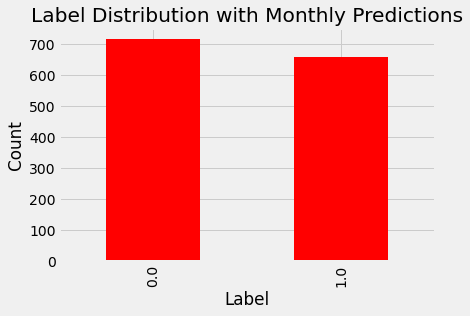

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Monthly Predictions');

In [41]:
label_times[label_times['customer_id']==1]

,customer_id,cutoff_time,label,days_to_churn,churn_date
0,1,1998-01-01,0.0,141.525822,NaT
1,1,1998-02-01,0.0,110.525822,NaT
2,1,1998-03-01,0.0,82.525822,NaT
3,1,1998-04-01,1.0,51.525822,1998-05-22 12:37:11
4,1,1998-05-01,1.0,21.525822,1998-06-13 11:24:32
...,...,...,...,...,...
272,1,2020-09-01,0.0,13.172951,NaT
273,1,2020-10-01,1.0,38.809063,2020-11-08 19:25:03
274,1,2020-11-01,1.0,7.809062,2020-12-25 16:07:49
275,1,2020-12-01,NaN,24.672095,NaT


In [46]:
CUSTOMER_ID = 1
customer_transactions = df.loc[df['customer_id'] == CUSTOMER_ID].copy()
label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'MS', churn_days = 2, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)

<ipython-input-8-c507fea34bae>:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
<ipython-input-8-c507fea34bae>:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_date = pd.datetime(last_transaction.year + 1, 1, 1)


In [47]:
label_times

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,1998-01-01,1998-02-01,1998-03-01,0.0,NaT,141.525822
1,1998-02-01,1998-03-01,1998-04-01,0.0,NaT,110.525822
2,1998-03-01,1998-04-01,1998-05-01,0.0,NaT,82.525822
3,1998-04-01,1998-05-01,1998-06-01,1.0,1998-05-22 12:37:11,51.525822
4,1998-05-01,1998-06-01,1998-07-01,1.0,1998-06-13 11:24:32,21.525822
...,...,...,...,...,...,...
272,2020-09-01,2020-10-01,2020-11-01,0.0,NaT,13.172951
273,2020-10-01,2020-11-01,2020-12-01,1.0,2020-11-08 19:25:03,38.809063
274,2020-11-01,2020-12-01,2021-01-01,1.0,2020-12-25 16:07:49,7.809062
275,2020-12-01,2021-01-01,NaT,NaN,NaT,24.672095


In [48]:
cust_transactions.head(10)

,customer_id,date,next_transaction_date,difference_days,churn,churn_date
2473,1,1998-01-01 06:46:46,1998-01-02 01:05:27,0.762975,False,NaT
10693,1,1998-01-02 01:05:27,1998-01-02 04:48:03,0.154583,False,NaT
91124,1,1998-01-02 04:48:03,1998-01-02 13:22:29,0.357245,False,NaT
22524,1,1998-01-02 13:22:29,1998-01-05 14:54:11,3.063681,True,1998-01-02 13:22:29
36974,1,1998-01-05 14:54:11,1998-01-06 06:12:46,0.637905,False,NaT
94774,1,1998-01-06 06:12:46,1998-01-06 09:21:57,0.131377,False,NaT
4707,1,1998-01-06 09:21:57,1998-01-06 18:04:12,0.362674,False,NaT
75227,1,1998-01-06 18:04:12,1998-01-07 11:49:09,0.739549,False,NaT
79635,1,1998-01-07 11:49:09,1998-01-07 15:11:18,0.140382,False,NaT
11532,1,1998-01-07 15:11:18,1998-01-08 03:11:07,0.499873,False,NaT


In [49]:
label_times.label.value_counts()

0.0    157
1.0    118
Name: label, dtype: int64